In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Constants
DATA_PATH = '../data/processed/preprocessed_v1.csv'

# Carreguem les dades
df = pd.read_csv(DATA_PATH)

# Variables per al clustering (les mateixes que es van usar originalment)
CLUSTERING_VARS = [
    'FIGO2023',
    'recep_est_porcent',
    'afectacion_linf',
    'grado_histologi',
    'edad',
    'imc',
    'infiltracion_mi',
    'rece_de_Ppor'
]

# Preparem les dades per al clustering
X = df[CLUSTERING_VARS].copy()

# Imputem valors faltants amb la mediana
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Escalem les dades
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apliquem K-Means (assumint k=3 com a l'anàlisi original)
N_CLUSTERS = 2
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

print(f"Dataset carregat: {df.shape[0]} files, {df.shape[1]} columnes")
print(f"Variables de clustering: {CLUSTERING_VARS}")
print(f"\nTotal d'individus per clúster:")
cluster_counts = df['cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"  Clúster {cluster}: {count} individus")
print(f"\nTotal: {cluster_counts.sum()} individus")

Dataset carregat: 154 files, 56 columnes
Variables de clustering: ['FIGO2023', 'recep_est_porcent', 'afectacion_linf', 'grado_histologi', 'edad', 'imc', 'infiltracion_mi', 'rece_de_Ppor']

Total d'individus per clúster:
  Clúster 0: 43 individus
  Clúster 1: 111 individus

Total: 154 individus


In [2]:
# Mapeig dels noms dels clústers segons les regles de negoci (Agent.MD)
# 0 -> Alt Risc (Sol·licitat)
# 1 -> Baix Risc (Sol·licitat)
# 2 -> Mitjà Risc (Deduït per completar els 3 nivells especificats a la documentació)
cluster_mapping = {
    0: 'Alt Risc',
    1: 'Baix Risc',
    2: 'Mitjà Risc'
}

# Apliquem el canvi de nom a la columna 'cluster'
if 'cluster' in df.columns:
    df['cluster'] = df['cluster'].replace(cluster_mapping)
    
# Verifiquem els nous noms
print(f"Nous noms de clústers: {df['cluster'].unique()}")

# Definir l'ordre correcte per a les visualitzacions (de menys a més risc o viceversa)
risk_order = ['Baix Risc', 'Mitjà Risc', 'Alt Risc']
df['cluster'] = pd.Categorical(df['cluster'], categories=risk_order, ordered=True)

Nous noms de clústers: ['Alt Risc' 'Baix Risc']


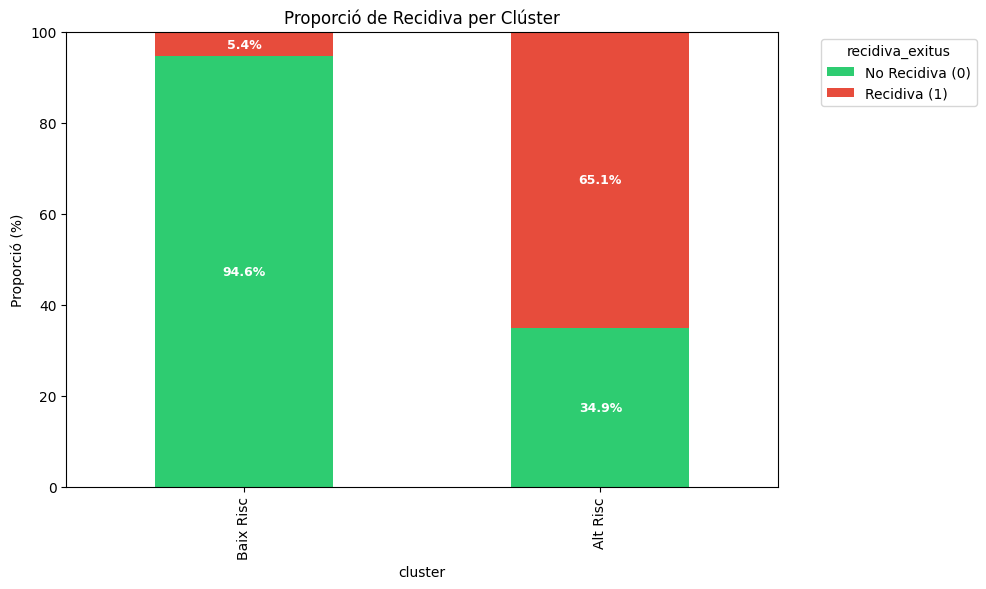

In [3]:
from matplotlib.colors import ListedColormap

def plot_stacked_normalized(df, x_col, hue_col, title):
    """
    Plots a normalized (100%) stacked bar chart showing proportions.
    Uses green (no recurrence) and red (recurrence) colors.
    """
    # Calculem la taula de contingència normalitzada
    crosstab = pd.crosstab(df[x_col], df[hue_col], normalize='index') * 100
    
    # Colors: Verd per 0 (no recidiva), Vermell per 1 (recidiva)
    colors = ['#2ecc71', '#e74c3c']  # Green, Red
    
    # Creem el gràfic
    ax = crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel('Proporció (%)')
    plt.legend(title=hue_col, labels=['No Recidiva (0)', 'Recidiva (1)'], 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 100)

    # Afegim els percentatges dins de les barres
    for c in ax.containers:
        labels = [f'{v.get_height():.1f}%' if v.get_height() > 5 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontweight='bold', fontsize=9, color='white')

    plt.tight_layout()
    plt.show()

# Visualitzem NOMÉS la proporció del target (recidiva) per clúster
plot_stacked_normalized(
    df, 
    x_col='cluster', 
    hue_col='recidiva_exitus', 
    title='Proporció de Recidiva per Clúster'
)

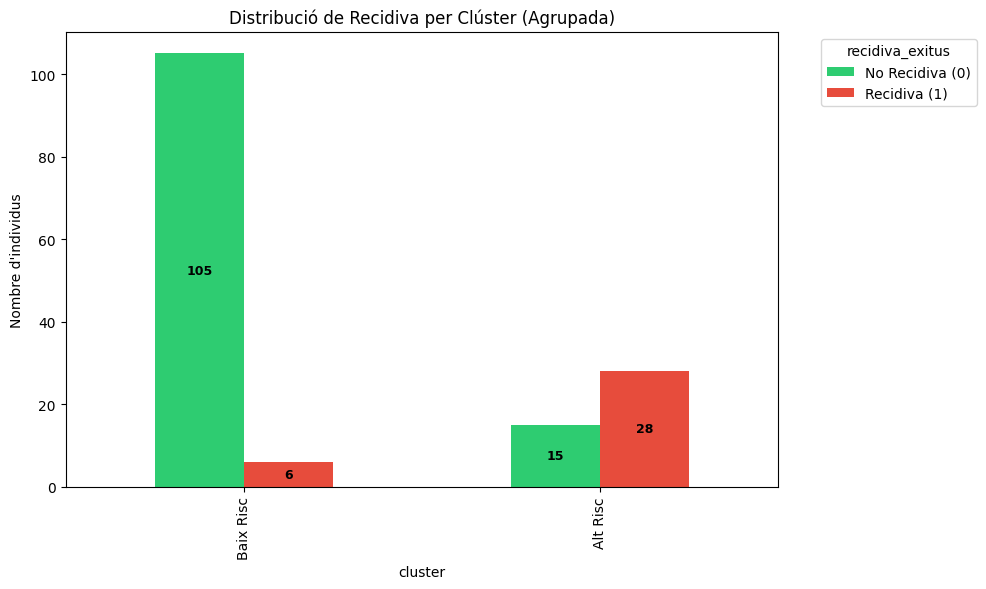

In [4]:
def plot_stacked_count_target(df, x_col, hue_col, title):
    """
    Plots a grouped bar chart showing counts (absolute numbers).
    Uses green (no recurrence) and red (recurrence) colors.
    """
    # Calculem la taula de contingència amb counts absoluts
    crosstab = pd.crosstab(df[x_col], df[hue_col])
    
    # Colors: Verd per 0 (no recidiva), Vermell per 1 (recidiva)
    colors = ['#2ecc71', '#e74c3c']  # Green, Red
    
    # Creem el gràfic - Canviat a stacked=False
    ax = crosstab.plot(kind='bar', stacked=False, figsize=(10, 6), color=colors)
    
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel('Nombre d\'individus') 
    plt.legend(title=hue_col, labels=['No Recidiva (0)', 'Recidiva (1)'], 
               bbox_to_anchor=(1.05, 1), loc='upper left')

    # Afegim els números absoluts dins de les barres
    for c in ax.containers:
        # Mostrem el valor absolut si és > 0
        labels = [f'{v.get_height():.0f}' if v.get_height() > 0 else '' for v in c]
        # Canviat color a 'black' per contrast sobre barres separades
        ax.bar_label(c, labels=labels, label_type='center', fontweight='bold', fontsize=9, color='black')

    plt.tight_layout()
    plt.show()

# Visualitzem Grouped Barchart de Recidiva per Clúster
plot_stacked_count_target(
    df, 
    x_col='cluster', 
    hue_col='recidiva_exitus', 
    title='Distribució de Recidiva per Clúster (Agrupada)'
)

In [5]:
def plot_area_distribution(df, col, cluster_col='cluster', title=None):
    """
    Plots overlapping area charts (KDE) for each cluster on the same axes.
    Uses highly differentiated colors.
    """
    clusters = sorted(df[cluster_col].unique())
    
    # Paleta de colors molt diferenciats
    colors = ['#3498db', '#e67e22', '#9b59b6', '#1abc9c', '#e74c3c']  # Blau, Taronja, Porpra, Turquesa, Vermell
    
    plt.figure(figsize=(10, 6))
    
    for i, cluster in enumerate(clusters):
        subset = df[df[cluster_col] == cluster][col].dropna()
        if len(subset) > 1:
            sns.kdeplot(
                data=subset, 
                fill=True, 
                alpha=0.35, 
                color=colors[i % len(colors)], 
                label=f'Clúster {cluster}',
                linewidth=2.5
            )
    
    plt.title(title if title else f'Distribució de {col} per Clúster')
    plt.xlabel(col)
    plt.ylabel('Densitat')
    plt.legend(title='Clúster')
    plt.tight_layout()
    plt.show()

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_area_distribution(df, col, cluster_col='cluster', title=None):
    """
    Plots overlapping area charts (KDE) for each cluster on the same axes.
    """
    clusters = sorted(df[cluster_col].unique())
    
    # CAMBIO: Paleta personalizada "Naranja y Azules"
    # Cluster 0 -> Naranja, Cluster 1 -> Azul fuerte, Cluster 2 -> Azul claro
    colors = ['#ff7f0e', '#1f77b4', '#aec7e8'] 
    
    # Si hay más de 3 clústers, extendemos con más tonos si fuera necesario
    if len(clusters) > len(colors):
         colors = sns.color_palette("Oranges_d", n_colors=len(clusters)) + sns.color_palette("Blues_d", n_colors=len(clusters))

    plt.figure(figsize=(10, 6))
    
    for i, cluster in enumerate(clusters):
        subset = df[df[cluster_col] == cluster][col].dropna()
        if len(subset) > 1:
            # KDE plot amb àrea omplerta
            # Usamos el color correspondiente al índice del clúster (asegurando no salirnos del rango)
            color_idx = i % len(colors)
            sns.kdeplot(
                data=subset, 
                fill=True, 
                alpha=0.4, 
                color=colors[color_idx], 
                label=f'Clúster {cluster}',
                linewidth=2
            )
    
    plt.title(title if title else f'Distribució de {col} per Clúster')
    plt.xlabel(col)
    plt.ylabel('Densitat')
    plt.legend(title='Clúster')
    plt.tight_layout()
    plt.show()

Generant gràfics per a les variables de clustering: ['FIGO2023', 'recep_est_porcent', 'afectacion_linf', 'grado_histologi', 'edad', 'imc', 'infiltracion_mi', 'rece_de_Ppor']


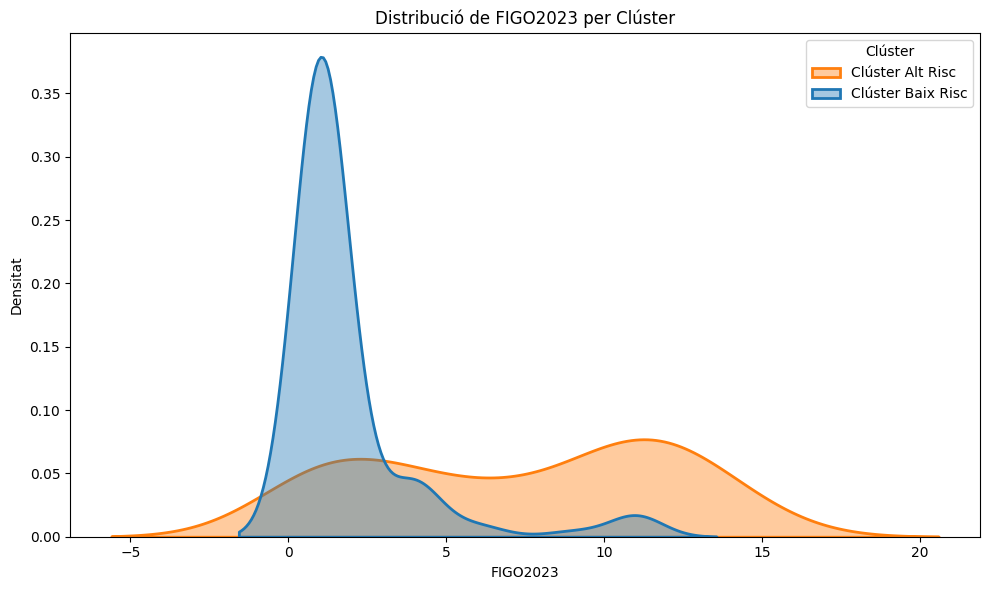

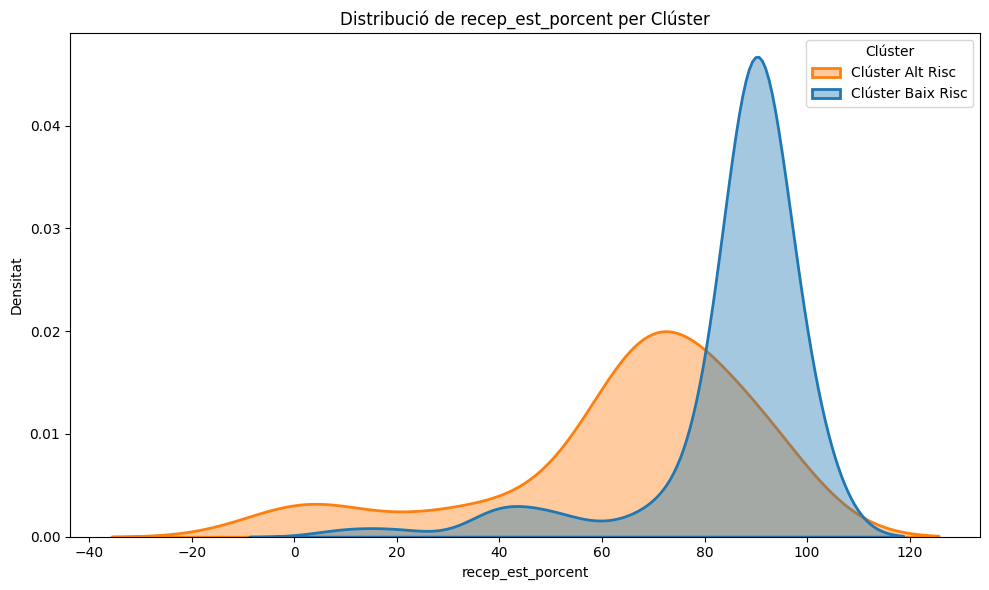

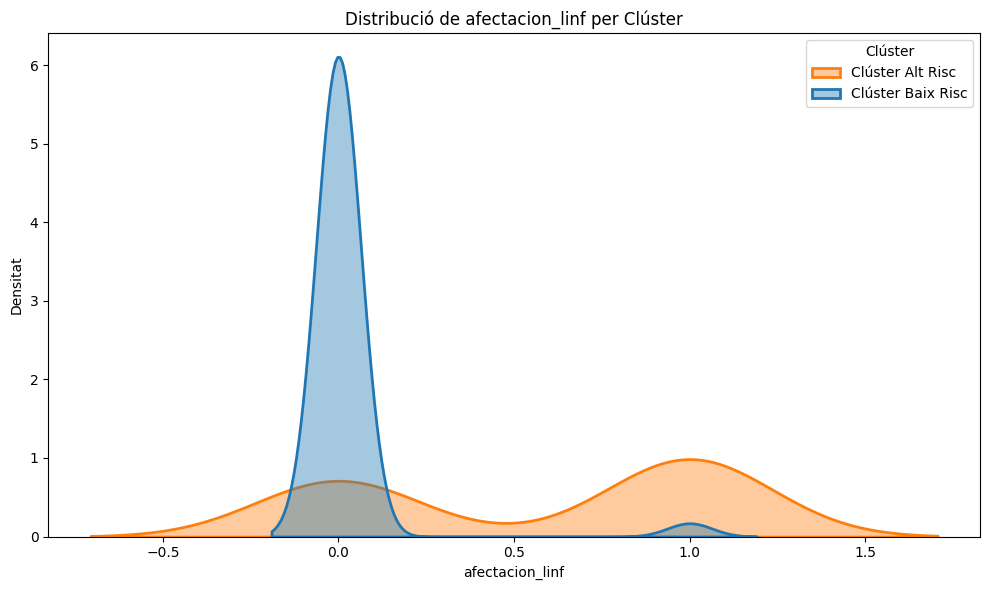

C:\Users\paugo\AppData\Local\Temp\ipykernel_3852\264190124.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


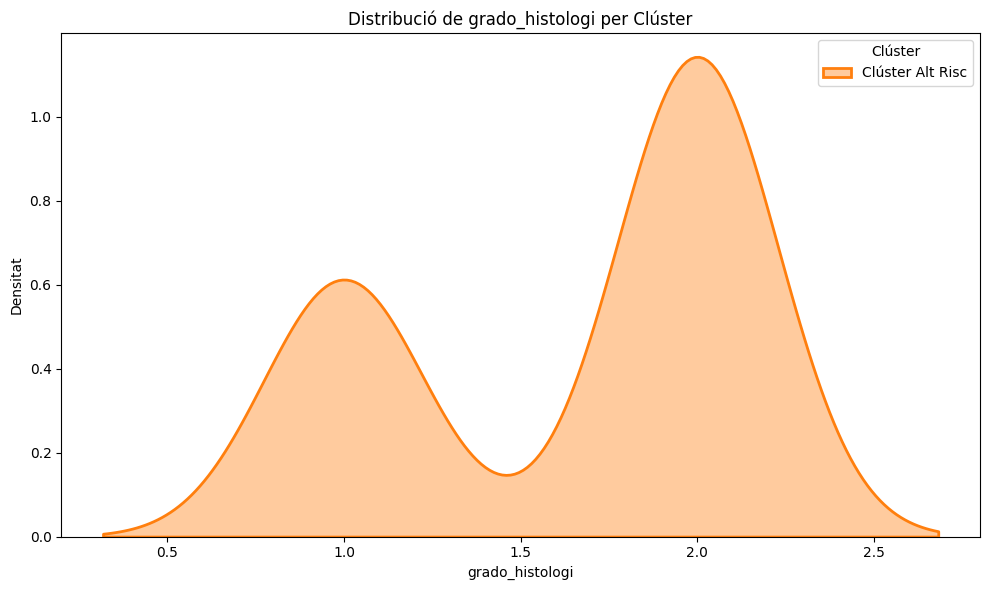

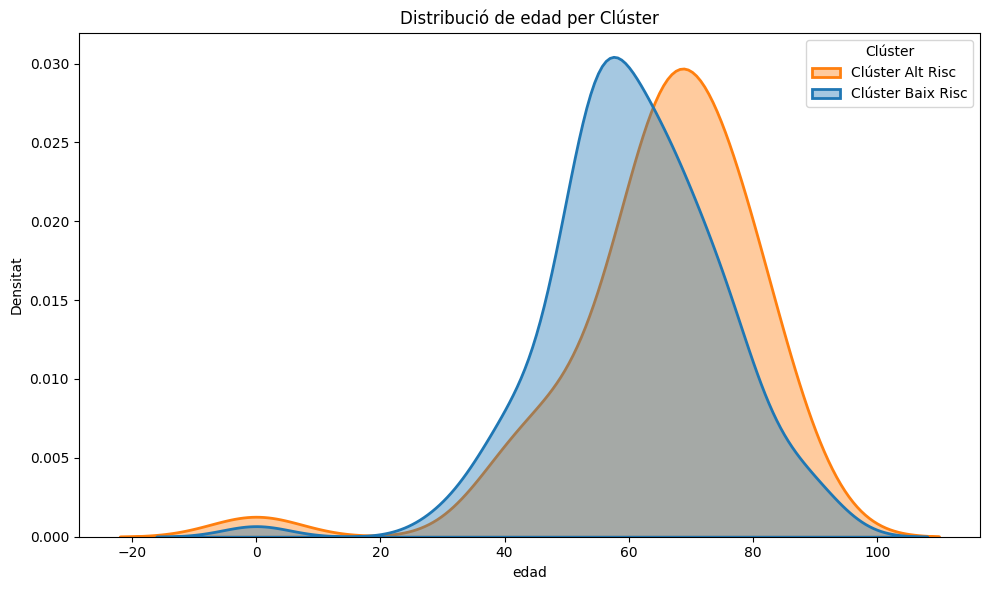

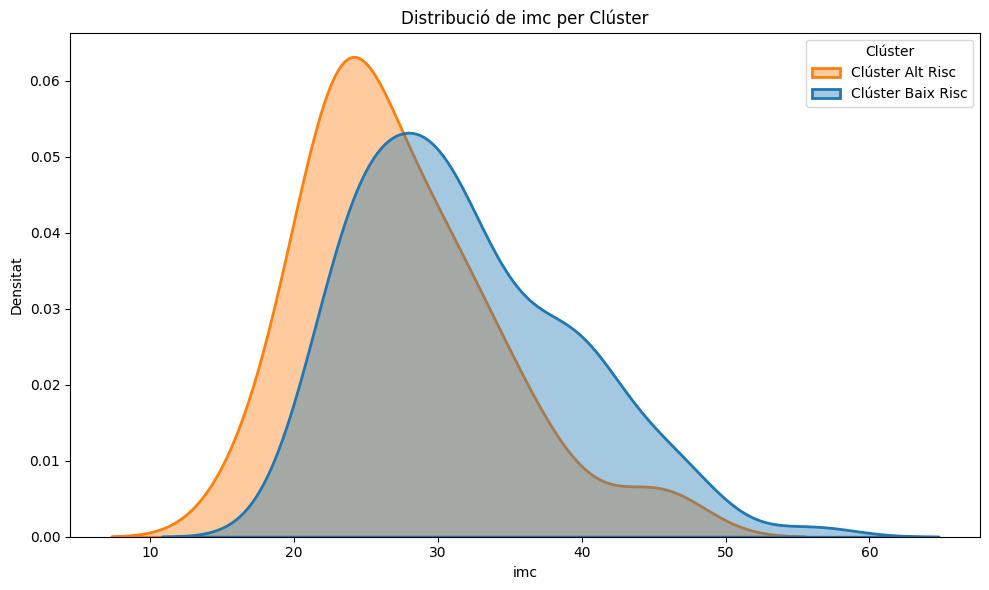

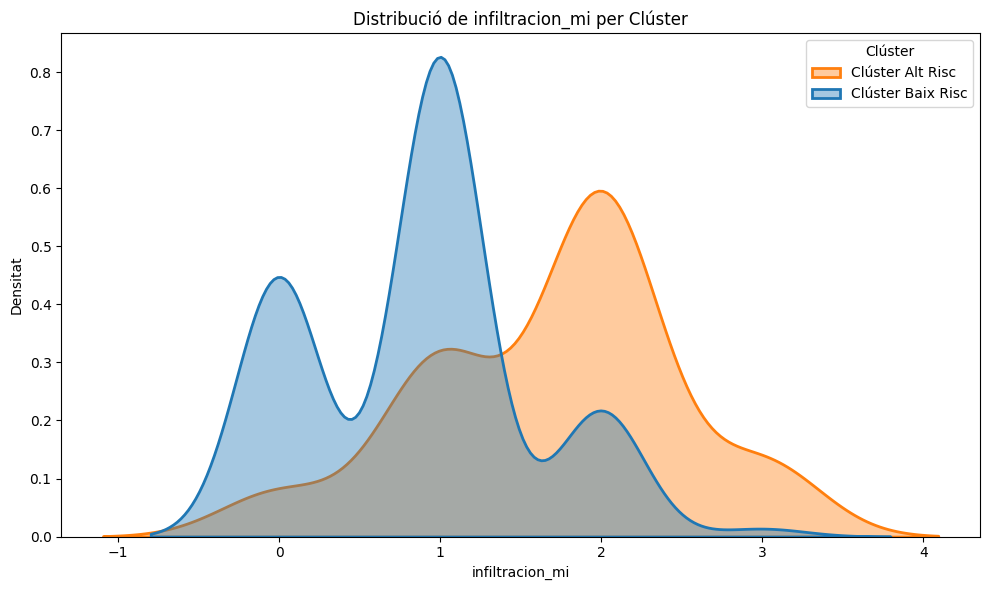

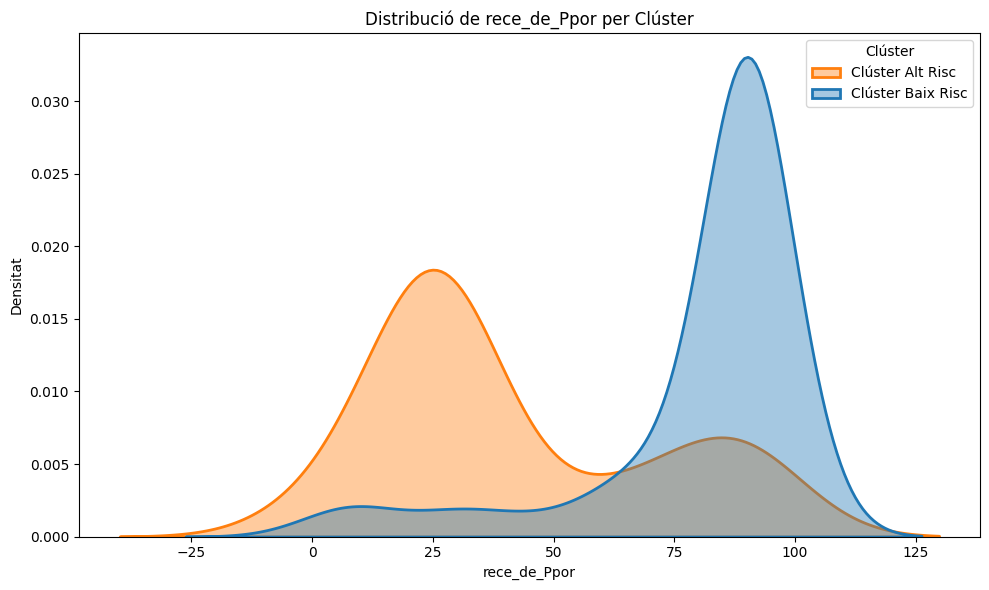

In [7]:
# Generem un area chart per a cada variable usada en el clustering
print(f"Generant gràfics per a les variables de clustering: {CLUSTERING_VARS}")

for col in CLUSTERING_VARS:
    plot_area_distribution(
        df, 
        col=col, 
        cluster_col='cluster',
        title=f'Distribució de {col} per Clúster'
    )

In [8]:
from sklearn.neighbors import NearestNeighbors

# Entrenem el model KNN amb les dades escalades
K_NEIGHBORS = 20
knn = NearestNeighbors(n_neighbors=K_NEIGHBORS, metric='euclidean')
knn.fit(X_scaled)

def predict_individual(individual_data, df, X_scaled, kmeans, knn, scaler, imputer, 
                        clustering_vars, k=5):
    """
    Dado un individuo, retorna:
    - El cluster al que pertenece
    - Los k casos más similares
    - La probabilidad estimada de recidiva
    
    Parameters:
    -----------
    individual_data : dict
        Diccionario con los valores de las variables de clustering
        Ejemplo: {'FIGO2023': 4, 'recep_est_porcent': 80, ...}
    """
    # Preparem les dades de l'individu
    individual_df = pd.DataFrame([individual_data])
    X_ind = individual_df[clustering_vars].values
    
    # Imputem i escalem
    X_ind_imputed = imputer.transform(X_ind)
    X_ind_scaled = scaler.transform(X_ind_imputed)
    
    # Determinem el cluster
    cluster = kmeans.predict(X_ind_scaled)[0]
    
    # Trobem els k veïns més propers
    distances, indices = knn.kneighbors(X_ind_scaled)
    
    # Obtenim els casos similars
    similar_cases = df.iloc[indices[0]].copy()
    similar_cases['distance'] = distances[0]
    
    # Calculem la probabilitat de recidiva
    recurrence_prob = similar_cases['recidiva_exitus'].mean()
    recurrence_count = similar_cases['recidiva_exitus'].sum()
    
    return {
        'cluster': cluster,
        'similar_cases': similar_cases,
        'recurrence_probability': recurrence_prob,
        'recurrence_count': recurrence_count,
        'total_neighbors': k
    }

def display_prediction(result):
    """
    Mostra els resultats de forma clara.
    """
    print("=" * 60)
    print("RESULTATS DE L'ANÀLISI")
    print("=" * 60)
    
    print(f"\n🔹 CLÚSTER ASSIGNAT: {result['cluster']}")
    
    print(f"\n🔹 PROBABILITAT DE RECIDIVA: {result['recurrence_probability']*100:.1f}%")
    print(f"   ({result['recurrence_count']}/{result['total_neighbors']} veïns amb recidiva)")
    
    # Semàfor de risc
    prob = result['recurrence_probability']
    if prob < 0.3:
        risk = "🟢 BAIX RISC"
    elif prob < 0.6:
        risk = "🟡 RISC MITJÀ"
    else:
        risk = "🔴 ALT RISC"
    print(f"\n🔹 NIVELL DE RISC: {risk}")
    
    print(f"\n🔹 CASOS MÉS SIMILARS (k={result['total_neighbors']}):")
    print("-" * 60)
    
    # Mostrem els casos similars amb informació rellevant
    display_cols = ['recidiva_exitus', 'distance'] + CLUSTERING_VARS
    display_df = result['similar_cases'][display_cols].copy()
    display_df['distance'] = display_df['distance'].round(3)
    print(display_df.to_string(index=True))
    
    print("=" * 60)

In [9]:
# Exemple: Definim un nou individu amb les seves característiques
nou_individu = {
    'FIGO2023': 4.0,          # Estadi FIGO
    'recep_est_porcent': 80.0, # Receptors estrogen (%)
    'afectacion_linf': 0.0,    # Afectació limfàtica (0=No, 1=Sí)
    'grado_histologi': 1.0,    # Grau histològic
    'edad': 65.0,              # Edat
    'imc': 32.0,               # IMC
    'infiltracion_mi': 2.0,    # Infiltració miometrial
    'rece_de_Ppor': 70.0       # Receptors progesterona (%)
}

# Fem la predicció
result = predict_individual(
    individual_data=nou_individu,
    df=df,
    X_scaled=X_scaled,
    kmeans=kmeans,
    knn=knn,
    scaler=scaler,
    imputer=imputer,
    clustering_vars=CLUSTERING_VARS,
    k=K_NEIGHBORS
)

# Mostrem els resultats
display_prediction(result)

RESULTATS DE L'ANÀLISI

🔹 CLÚSTER ASSIGNAT: 1

🔹 PROBABILITAT DE RECIDIVA: 5.0%
   (1/20 veïns amb recidiva)

🔹 NIVELL DE RISC: 🟢 BAIX RISC

🔹 CASOS MÉS SIMILARS (k=20):
------------------------------------------------------------
     recidiva_exitus  distance  FIGO2023  recep_est_porcent  afectacion_linf  grado_histologi  edad   imc  infiltracion_mi  rece_de_Ppor
148                0     0.665       4.0               90.0              0.0              1.0  63.0  28.7              2.0          70.0
143                0     0.974       6.0               90.0              0.0              1.0  64.0  32.8              2.0          90.0
17                 0     0.996       4.0               90.0              0.0              1.0  58.0  34.1              2.0          90.0
141                0     1.052       4.0               90.0              0.0              1.0  73.0  29.4              2.0          90.0
114                0     1.245       4.0              100.0              0.0        

c:\Users\paugo\OneDrive\Desktop\bitsXlamarato-2025-oncometric\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [10]:
def input_individual():
    """
    Funció interactiva per introduir les dades d'un individu.
    """
    print("Introdueix les dades del pacient:")
    print("-" * 40)
    
    individual = {
        'FIGO2023': float(input("FIGO2023 (1-14): ")),
        'recep_est_porcent': float(input("Receptors Estrogen % (0-100): ")),
        'afectacion_linf': float(input("Afectació Limfàtica (0=No, 1=Sí): ")),
        'grado_histologi': float(input("Grau Histològic (1 o 2): ")),
        'edad': float(input("Edat: ")),
        'imc': float(input("IMC: ")),
        'infiltracion_mi': float(input("Infiltració Miometrial (0-3): ")),
        'rece_de_Ppor': float(input("Receptors Progesterona % (0-100): "))
    }
    
    return individual

# Per usar la funció interactiva, descomenta les línies següents:
# nou_individu = input_individual()
# result = predict_individual(nou_individu, df, X_scaled, kmeans, knn, scaler, imputer, CLUSTERING_VARS, K_NEIGHBORS)
# display_prediction(result)

In [11]:
# --- ANÀLISI DE COMPONENTS PRINCIPALS (PCA) ---
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Aplicar PCA (2 Components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. Crear DataFrame amb resultats
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['cluster']
if 'recidiva_exitus' in df.columns:
    pca_df['Target'] = df['recidiva_exitus']
    pca_df['Target_Label'] = pca_df['Target'].map({0: 'No Recidiva', 1: 'Recidiva'})

print("PCA calculat correctament.")
print(f"Variança explicada per component: {pca.explained_variance_ratio_}")
print(f"Variança total explicada (2 components): {sum(pca.explained_variance_ratio_):.4f}")

PCA calculat correctament.
Variança explicada per component: [0.37282514 0.16794808]
Variança total explicada (2 components): 0.5408


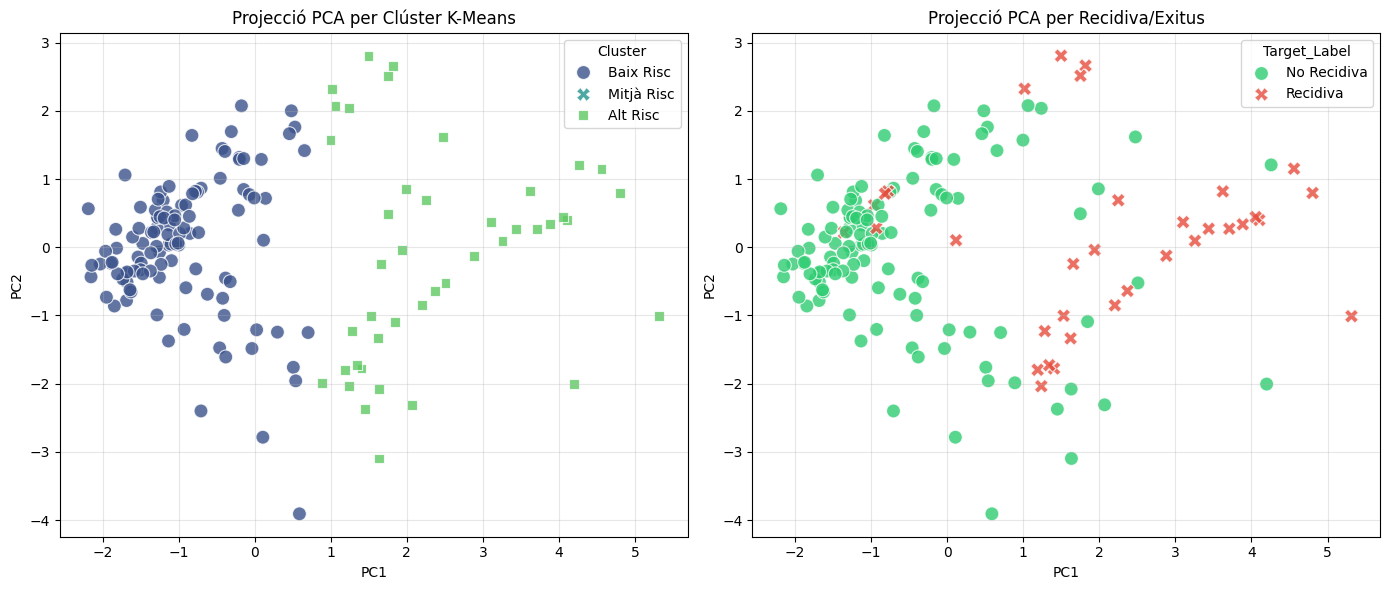

In [12]:
# 3. Visualització del PCA
plt.figure(figsize=(14, 6))

# Plot 1: PCA per Clúster
plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', style='Cluster', s=100, alpha=0.8)
plt.title('Projecció PCA per Clúster K-Means')
plt.grid(True, alpha=0.3)

# Plot 2: PCA per Target (Recidiva)
if 'Target' in pca_df.columns:
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='PC1', y='PC2', hue='Target_Label', data=pca_df, 
                    palette={'No Recidiva': '#2ecc71', 'Recidiva': '#e74c3c'}, style='Target_Label', s=100, alpha=0.8)
    plt.title('Projecció PCA per Recidiva/Exitus')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

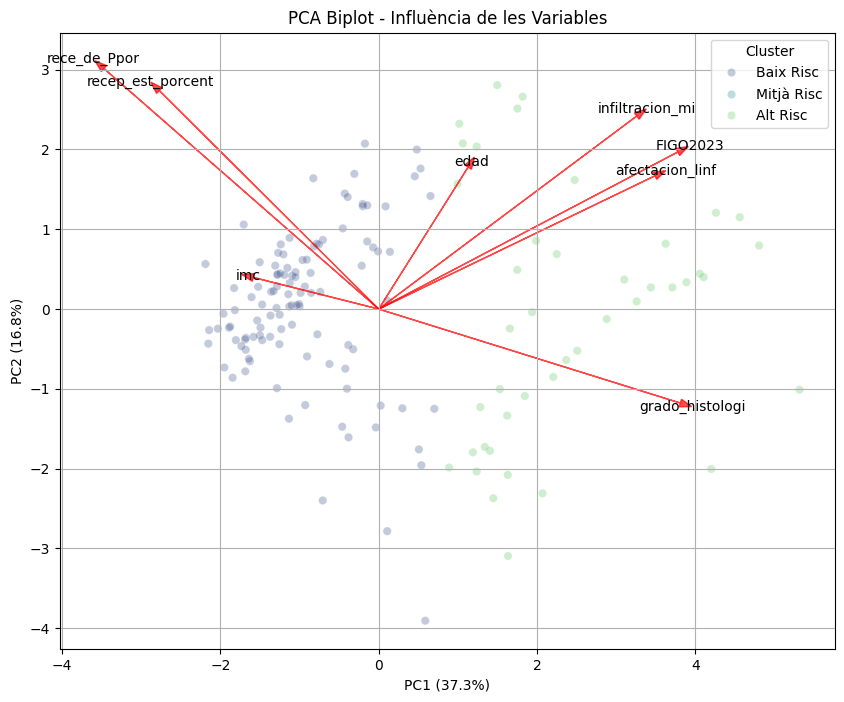

In [13]:
# 4. Biplot (Opcional - per veure influència de variables)
# Aquest gràfic mostra quines variables contribueixen més a PC1 i PC2
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.3)

# Reconstruct loadings scaled
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
features = CLUSTERING_VARS

for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0]*5, loadings[i, 1]*5, color='r', alpha=0.7, head_width=0.1)
    plt.text(loadings[i, 0]*5.2, loadings[i, 1]*5.2, feature, color='black', ha='center', va='center')

plt.title('PCA Biplot - Influència de les Variables')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.grid()
plt.show()

In [14]:
df = pd.read_csv('C:/Users/paugo/OneDrive/Desktop/bitsXlamarato-2025-oncometric/data/processed/preprocessed_v1.csv')

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def perform_pca_clustering_biplot(df, clustering_vars, n_clusters=2):
    """
    Realitza Clustering K-Means i PCA i mostra NOMÉS el Biplot final.
    """

    # 1. Preparar dades
    df_analysis = df.copy()
    X = df_analysis[clustering_vars].copy()
    
    # Imputar i Escalar
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_analysis['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Mapeig de noms
    cluster_mapping = {0: 'Alt Risc', 1: 'Baix Risc'}
    if 'cluster' in df_analysis.columns:
        df_analysis['cluster'] = df_analysis['cluster'].replace(cluster_mapping)
        
    risk_order = ['Baix Risc', 'Alt Risc']
    existing_categories = [c for c in risk_order if c in df_analysis['cluster'].unique()]
    df_analysis['cluster'] = pd.Categorical(df_analysis['cluster'], categories=existing_categories, ordered=True)
    
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = df_analysis['cluster']

    CUSTOM_PALETTE = ['#3498db', '#e67e22', '#9b59b6', '#1abc9c', '#e74c3c']
    
    plt.figure(figsize=(10, 8))
    
    # Fons de punts (clusters)
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, 
                    palette=sns.color_palette(CUSTOM_PALETTE, n_colors=len(pca_df['Cluster'].unique())), 
                    alpha=0.4, legend=True)
    
    # Fletxes (Variables)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    features = clustering_vars
    scale_arrow = 5 
    
    for i, feature in enumerate(features):
        plt.arrow(0, 0, loadings[i, 0]*scale_arrow, loadings[i, 1]*scale_arrow, 
                  color='r', alpha=0.9, head_width=0.15, linewidth=1.2)
        plt.text(loadings[i, 0]*scale_arrow*1.15, loadings[i, 1]*scale_arrow*1.15, feature, 
                 color='black', ha='center', va='center', fontsize=10, fontweight='bold')
        
    plt.title('Biplot: Variables i Clústers')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    plt.grid(True, alpha=0.3)
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')
    plt.show()
    
    return df_analysis, kmeans, pca

In [17]:
clust_list1 = [
    ['FIGO2023','recep_est_porcent','afectacion_linf',
    'grado_histologi','edad','imc','infiltracion_mi','rece_de_Ppor'
    ],
]

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def perform_pca_clustering_biplot2(df, clustering_vars, n_clusters=2):
    """
    Realitza Clustering K-Means i PCA i mostra NOMÉS el Biplot final.
    Colors fixats: Baix Risc (Blau), Alt Risc (Taronja).
    """

    # 1. Preparar dades
    df_analysis = df.copy()
    X = df_analysis[clustering_vars].copy()
    
    # Imputar i Escalar
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_analysis['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Mapeig de noms
    cluster_mapping = {0: 'Baix Risc', 1: 'Alt Risc'}
    if 'cluster' in df_analysis.columns:
        df_analysis['cluster'] = df_analysis['cluster'].replace(cluster_mapping)
        
    risk_order = ['Baix Risc', 'Alt Risc']
    # Assegurem que l'ordre és aquest per assignar colors correctament
    existing_categories = [c for c in risk_order if c in df_analysis['cluster'].unique()]
    df_analysis['cluster'] = pd.Categorical(df_analysis['cluster'], categories=existing_categories, ordered=True)
    
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = df_analysis['cluster']
    
    # --- NOMÉS BIPLOT ---
    
    # DEFINIM COLORS MANUALMENT DICCIONARI:
    color_dict = {
        'Baix Risc': '#3498db', # BLAU
        'Alt Risc': '#FF8C00'   # TARONJA (DarkOrange) o '#e67e22'
    }
    
    plt.figure(figsize=(10, 8))
    
    # Fons de punts (clusters)
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, 
                    palette=color_dict, # Usem el diccionari directament
                    alpha=0.4, legend=True)
    
    # Fletxes (Variables)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    features = clustering_vars
    scale_arrow = 5 
    
    for i, feature in enumerate(features):
        plt.arrow(0, 0, loadings[i, 0]*scale_arrow, loadings[i, 1]*scale_arrow, 
                  color='r', alpha=0.9, head_width=0.15, linewidth=1.2)
        plt.text(loadings[i, 0]*scale_arrow*1.15, loadings[i, 1]*scale_arrow*1.15, feature, 
                 color='black', ha='center', va='center', fontsize=10, fontweight='bold')
        
    plt.title('Biplot: Variables i Clústers')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    plt.grid(True, alpha=0.3)
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')
    plt.show()
    
    return df_analysis, kmeans, pca

In [19]:
clust_list2 = [  
    ['FIGO2023','recep_est_porcent','afectacion_linf',
    'grado_histologi','edad','imc','infilt_estr_cervix','rece_de_Ppor'
    ],

    ['FIGO2023','recep_est_porcent','afectacion_linf',
    'grado_histologi','ap_gPor_afect_tot','imc','infiltracion_mi','rece_de_Ppor'
    ], 

    ['FIGO2023','recep_est_porcent','afectacion_linf',
    'grado_histologi','edad','n_total_GC','infiltracion_mi','rece_de_Ppor'
    ],
]

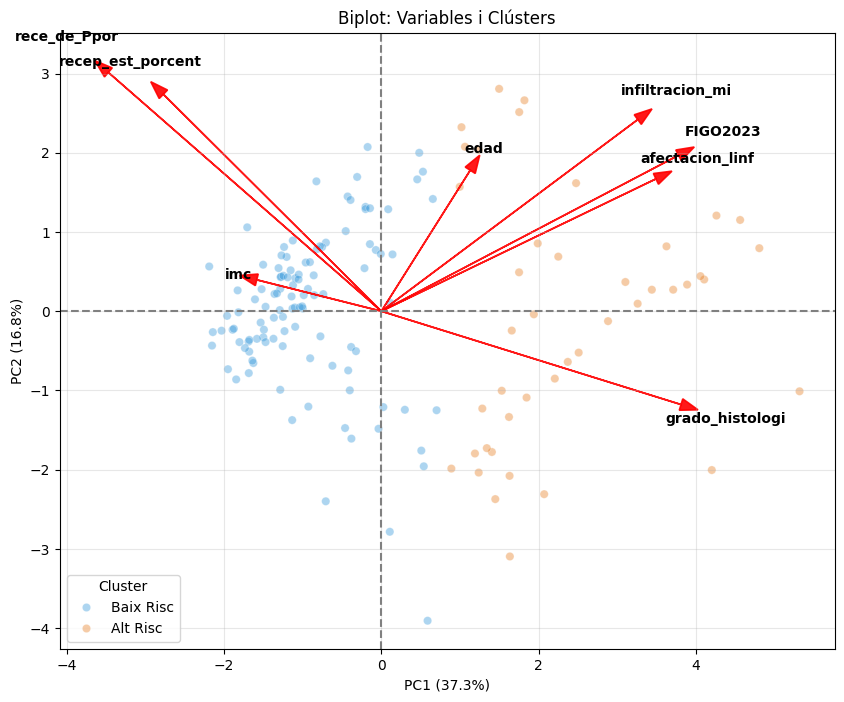

In [20]:
for cluster in clust_list1:
    df_analysis, _,_ = perform_pca_clustering_biplot(df, cluster)

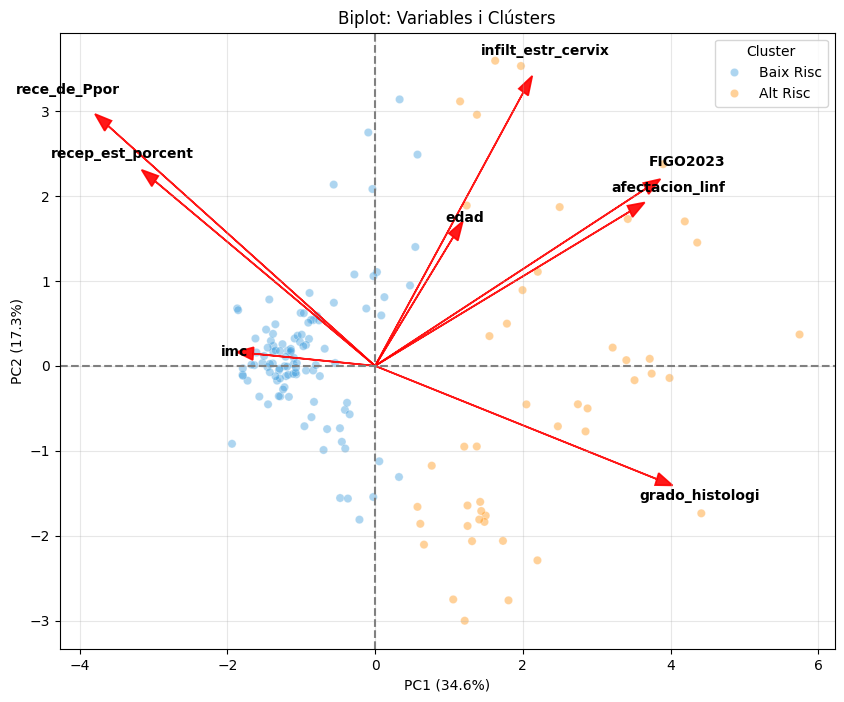

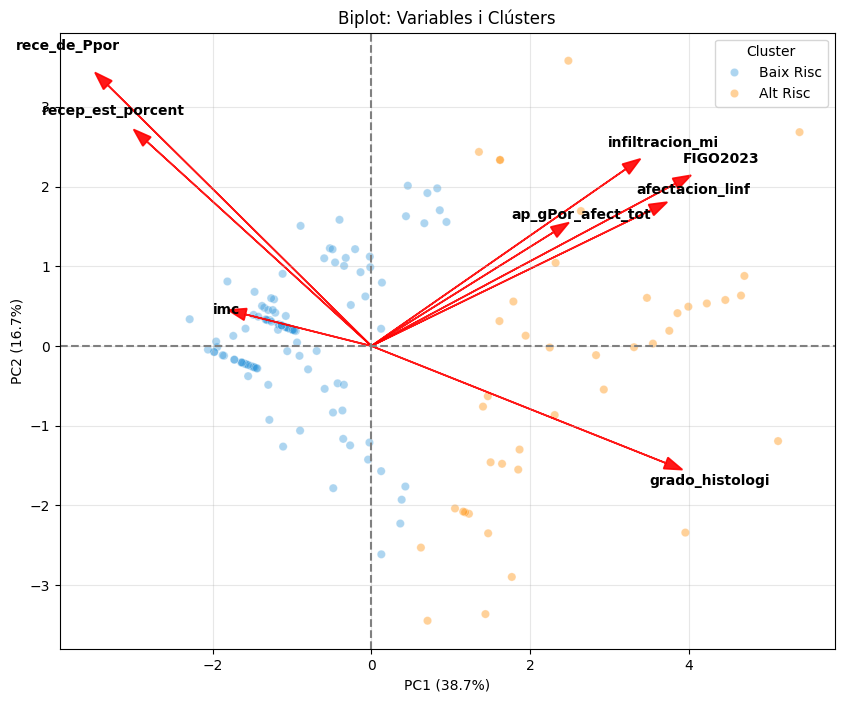

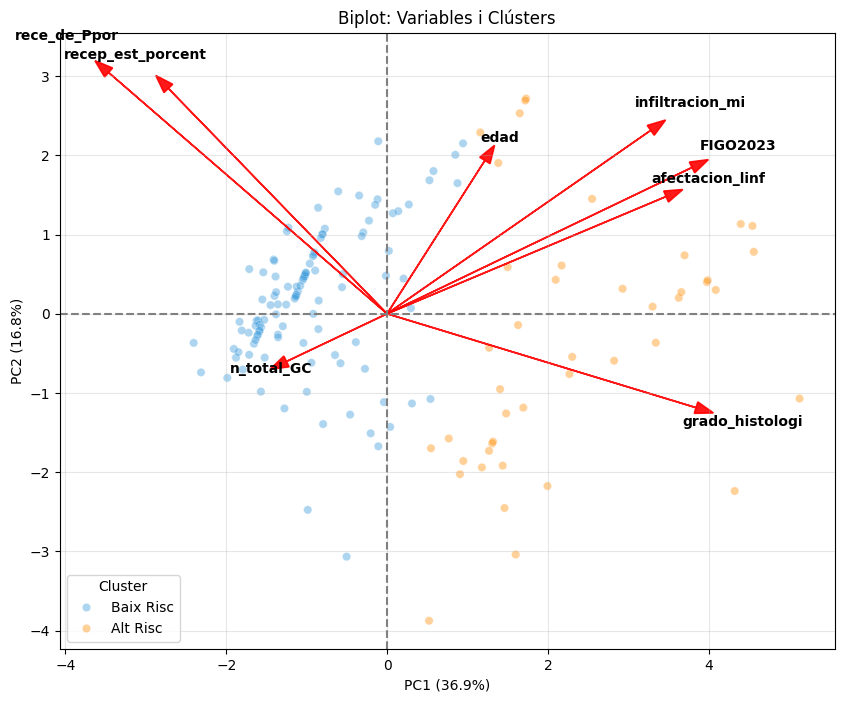

In [21]:
for cluster in clust_list2:
    perform_pca_clustering_biplot2(df, cluster)

C:\Users\paugo\AppData\Local\Temp\ipykernel_3852\582397297.py:24: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='Variable', y='Mitjana Estandaritzada (Z-Score)', hue='Cluster',


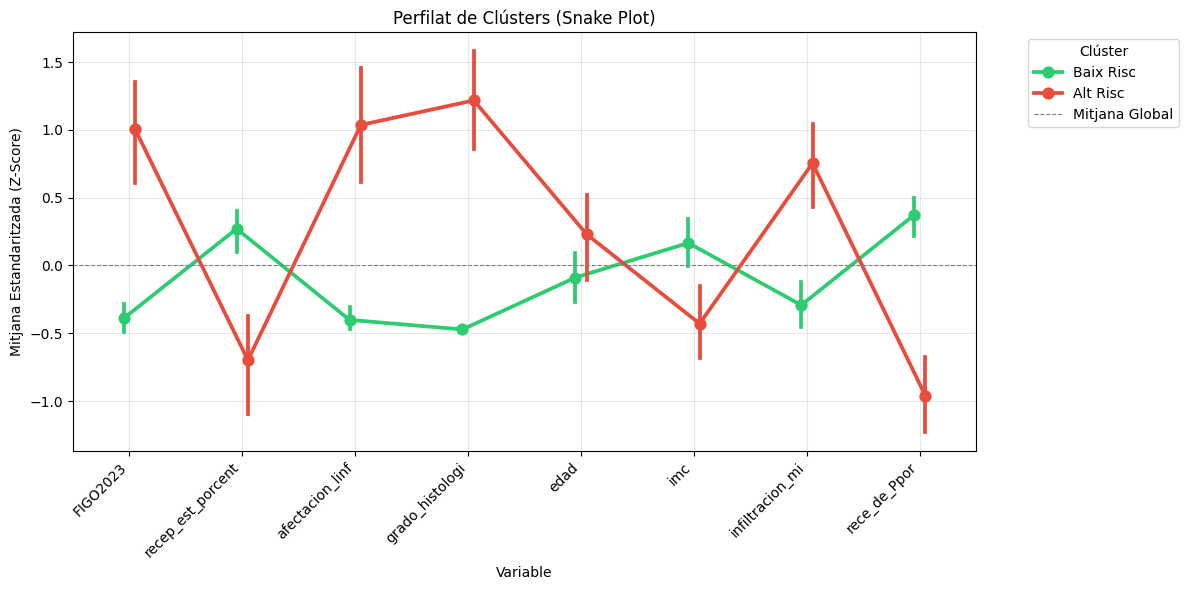

In [22]:
def plot_cluster_profiles_snake(df, clustering_vars, cluster_col='cluster'):
    """
    Crea un 'Snake Plot' per comparar els perfils dels clústers.
    Estandaritza les dades abans de plotjejar per fer-les comparables.
    """
    
    # 1. Escalar les dades (Z-score) per poder comparar variables diferents
    X = df[clustering_vars].copy()
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=clustering_vars)
    
    # Afegim el cluster
    X_scaled['Cluster'] = df[cluster_col].values
    
    # 2. "Melt" (Transformar a format llarg per a Seaborn)
    df_melted = pd.melt(X_scaled, id_vars=['Cluster'], 
                        value_vars=clustering_vars,
                        var_name='Variable', value_name='Mitjana Estandaritzada (Z-Score)')
    
    # 3. Plot
    plt.figure(figsize=(12, 6))
    
    # Gràfic de Punts connectats (Pointplot) o Línia
    sns.pointplot(x='Variable', y='Mitjana Estandaritzada (Z-Score)', hue='Cluster', 
                  data=df_melted, palette=['#2ecc71', '#e74c3c'],  # Verd/Vermell (ajusta segons clústers)
                  markers='o', dodge=0.1, join=True)
    
    plt.title('Perfilat de Clústers (Snake Plot)')
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8, label="Mitjana Global")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.legend(title='Clúster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Execució
# Assegura't de passar el 'df_analysis' que té la columna 'cluster' ja assignada
plot_cluster_profiles_snake(df_analysis, CLUSTERING_VARS)

In [23]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def analyze_pca_angles(df, target_vars):
    """
    Calcula angles respecte als eixos PC1/PC2 i busca la variable més similar
    per a cada variable de target_vars.
    """
    
    # 1. Seleccionar totes les variables numèriques per tenir context global
    # Excloem columnes que clarament no són features (id, cluster, recidiva si no volem que influeixi)
    exclude_cols = ['id_participante', 'cluster', 'recidiva_exitus', 'codigo_participante']
    numeric_df = df.select_dtypes(include=[np.number]).drop(columns=exclude_cols, errors='ignore')
    
    # Assegurem que les target_vars hi éstiguin
    missing = [v for v in target_vars if v not in numeric_df.columns]
    if missing:
        print(f"Alerta: Variables no trobades o no numèriques: {missing}")
        # Les traiem de l'anàlisi o forcem la seva inclusió si es poden convertir
    
    # 2. Preprocessament (Imputació + Escalat)
    X = numeric_df.copy()
    imputer = SimpleImputer(strategy='median')
    X_imp = imputer.fit_transform(X)
    scaler = StandardScaler()
    X_sc = scaler.fit_transform(X_imp)
    
    # 3. PCA (2 Components)
    pca = PCA(n_components=2)
    pca.fit(X_sc)
    
    components = pca.components_.T # Shape (n_features, 2)
    loadings = components * np.sqrt(pca.explained_variance_)
    
    # Índexs per a cerca ràpida
    feature_names = numeric_df.columns.tolist()
    
    # Funció auxiliar per calcular angle entre dos vectors
    def angle_between(v1, v2):
        # Angle en graus entre 0 i 180
        cos_sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        # Corregir errors de precisió
        cos_sim = np.clip(cos_sim, -1.0, 1.0)
        return np.degrees(np.arccos(cos_sim))

    # Funció per angle absolut amb l'eix (0 a 360 o -180 a 180)
    def angle_with_axis(v):
        # Arctan2 retorna radians entre -pi i pi
        rads = np.arctan2(v[1], v[0])
        deg = np.degrees(rads)
        return deg # -180 a 180
        
    results = []
    
    # Vectors unitaris dels eixos
    vec_x = np.array([1, 0])
    vec_y = np.array([0, 1])
    
    print(f"Analitzant {len(target_vars)} variables clau contra {len(feature_names)} totals...\n")
    
    for var in target_vars:
        if var not in feature_names:
            continue
            
        idx = feature_names.index(var)
        vec_var = loadings[idx]
        
        # 1. Angles amb eixos
        ang_x = angle_between(vec_var, vec_x)
        # Per saber si "apunta a la dreta o esquerra" (0-90 vs 90-180)
        # Però l'usuari demana angle concret. angle_between sempre dóna positiu menor.
        # Si volem direcció exacta (-180 a 180):
        ang_dir_x = angle_with_axis(vec_var)
        
        # Angle amb Y
        ang_y = angle_between(vec_var, vec_y)
        
        # 2. Buscar la variable més semblant (menor angle)
        min_angle = 180
        best_match = None
        
        for other_var in feature_names:
            if other_var == var:
                continue
                
            other_idx = feature_names.index(other_var)
            other_vec = loadings[other_idx]
            
            curr_angle = angle_between(vec_var, other_vec)
            
            if curr_angle < min_angle:
                min_angle = curr_angle
                best_match = other_var
        
        results.append({
            'Variable': var,
            'Angle vs X (PC1)': round(ang_x, 1),
            'Angle vs Y (PC2)': round(ang_y, 1),
            'Var. Més Semblant': best_match,
            'Angle Diferència': round(min_angle, 1)
        })
        
    # Crear DataFrame de resultats
    res_df = pd.DataFrame(results)
    return res_df

# --- EXECUCIÓ ---
CLUSTERING_VARS = [
    'FIGO2023',
    'recep_est_porcent',
    'afectacion_linf',
    'grado_histologi',
    'edad',
    'imc',
    'infiltracion_mi',
    'rece_de_Ppor'
]

# Assumint que 'df' ja està carregat al notebook
df_angles = analyze_pca_angles(df, CLUSTERING_VARS)

print("TAULA D'ANGLES I SIMILITUDS:")
display(df_angles)

Analitzant 8 variables clau contra 53 totals...

TAULA D'ANGLES I SIMILITUDS:


,Variable,Angle vs X (PC1),Angle vs Y (PC2),Var. Més Semblant,Angle Diferència
0,FIGO2023,3.7,93.7,edad,1.1
1,recep_est_porcent,178.3,91.7,abordajeqx,22.2
2,afectacion_linf,10.9,79.1,infiltracion_mi,1.4
3,grado_histologi,23.8,113.8,grupo_riesgo,0.7
4,edad,2.6,92.6,FIGO2023,1.1
5,imc,137.3,47.3,n_total_GC,4.7
6,infiltracion_mi,12.3,77.7,afectacion_linf,1.4
7,rece_de_Ppor,155.7,65.7,histe_avanz,2.5


In [24]:
def analyze_all_variables_angles_disjoint_modules(df, reference_vars):
    exclude = ['id_participante', 'cluster', 'recidiva_exitus', 'codigo_participante']
    numeric_df = df.select_dtypes(include=[np.number]).drop(columns=exclude, errors='ignore')
    all_features = numeric_df.columns.tolist()

    candidate_vars = [v for v in all_features if v not in reference_vars]
    
    X = numeric_df.copy()
    imputer = SimpleImputer(strategy='median')
    X_imp = imputer.fit_transform(X)
    X_sc = StandardScaler().fit_transform(X_imp)
    
    pca = PCA(n_components=2)
    pca.fit(X_sc)

    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    vec_x = np.array([1, 0])
    vec_y = np.array([0, 1])
    
    ref_idx_map = {name: i for i, name in enumerate(all_features)}
    ref_info = {}
    
    def get_angle(v1, v2):
        cos = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        return np.degrees(np.arccos(np.clip(cos, -1, 1)))

    for ref in reference_vars:
        if ref in ref_idx_map:
            idx = ref_idx_map[ref]
            vec = loadings[idx]
            ref_info[ref] = {
                'x': get_angle(vec, vec_x),
                'y': get_angle(vec, vec_y),
                'mod': np.linalg.norm(vec)
            }
    
    results = []
    
    for var_name in candidate_vars:
        idx = ref_idx_map[var_name]
        vec_var = loadings[idx]
        mod_var = np.linalg.norm(vec_var)
        
        ang_x = get_angle(vec_var, vec_x)
        ang_y = get_angle(vec_var, vec_y)
        
        best_match = "N/A"
        min_angle_diff = 180
        match_ang_x = np.nan
        match_ang_y = np.nan
        match_mod = np.nan
        
        for ref_var in reference_vars:
            if ref_var not in ref_idx_map: continue
            
            ref_idx = ref_idx_map[ref_var]
            ref_vec = loadings[ref_idx]
            
            diff = get_angle(vec_var, ref_vec)
            
            if diff < min_angle_diff:
                min_angle_diff = diff
                best_match = ref_var
                match_ang_x = ref_info[ref_var]['x']
                match_ang_y = ref_info[ref_var]['y']
                match_mod = ref_info[ref_var]['mod']
                
        results.append({
            'Variable Candidate': var_name,
            'Mòdul Candidat': round(mod_var, 3),
            'Angle X': round(ang_x, 1),
            'Angle Y': round(ang_y, 1),
            'Més Semblant (Cluster)': best_match,
            'Mòdul Ref': round(match_mod, 3) if best_match != "N/A" else "-", # NOVA COLUMNA
            'Ref Angle X': round(match_ang_x, 1) if best_match != "N/A" else "-",
            'Ref Angle Y': round(match_ang_y, 1) if best_match != "N/A" else "-",
            'Diferència Angle': round(min_angle_diff, 1)
        })
        
    return pd.DataFrame(results).sort_values('Diferència Angle')

df_final = analyze_all_variables_angles_disjoint_modules(df, CLUSTERING_VARS)
exclude_refs = []
df_filtered = df_final[~df_final['Més Semblant (Cluster)'].isin(exclude_refs)]
print(f"Mostrant resultats filtrats (exclosos: {exclude_refs})")
display(df_filtered)

Mostrant resultats filtrats (exclosos: [])


,Variable Candidate,Mòdul Candidat,Angle X,Angle Y,Més Semblant (Cluster),Mòdul Ref,Ref Angle X,Ref Angle Y,Diferència Angle
5,grupo_riesgo,0.798,24.6,114.6,grado_histologi,0.711,23.8,113.8,0.7
20,tamano_tumoral,0.319,22.2,112.2,grado_histologi,0.711,23.8,113.8,1.6
38,ap_gPor_afect_tot,0.482,1.0,91.0,edad,0.255,2.6,92.6,1.6
21,infilt_estr_cervix,0.422,9.3,80.7,afectacion_linf,0.627,10.9,79.1,1.7
3,ecotv_infiltobj,0.271,5.6,95.6,FIGO2023,0.834,3.7,93.7,1.9
40,grupo_de_riesgo_definitivo,0.851,5.7,95.7,FIGO2023,0.834,3.7,93.7,2.0
30,n_gangP_afec,0.562,0.3,90.3,edad,0.255,2.6,92.6,2.3
18,histe_avanz,0.355,153.3,63.3,rece_de_Ppor,0.417,155.7,65.7,2.5
28,AP_ganPelv,0.649,15.8,74.2,infiltracion_mi,0.685,12.3,77.7,3.4
44,Tratamiento_sistemico_realizad,0.709,19.8,109.8,grado_histologi,0.711,23.8,113.8,4.0
